In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in [0, 1,2,3]])

In [2]:
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm_notebook as tqdm
from __future__ import division
import pandas as pd
import seaborn as sb
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy
from torchvision.transforms import Resize
import dill
from joblib import Parallel, delayed
import cv2
import resource
import apex # https://github.com/NVIDIA/apex.git
from apex.amp import amp

import os, sys, datetime
import itertools
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
gen = False
# gen = True
cuda=True
# cnmf=True
cnmf=False
half=True
half=False
multi_gpu = True
num_workers = 16
prev_frames = 5
next_frames = 5

f = all_data['e'][2]

frame_times = T.from_numpy(f.frame_st.mean(1).astype(np.float32))
shocks = T.FloatTensor(frame_times.shape).zero_()
shocks[numpy.searchsorted(f.frame_et[:,-1], f.shock_st,side="left")] = 1

tail_movements = T.FloatTensor(frame_times.shape).zero_()
tail_movements[numpy.searchsorted(f.frame_et[:,-1],
    f.tail_movement_start_times,side="left")] = 1

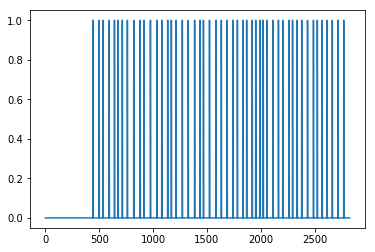

In [5]:
plt.plot(shocks.numpy())

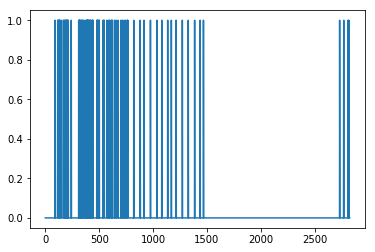

In [6]:
plt.plot(tail_movements.numpy())

In [7]:
def get_frames_from_z(z, fish,half=False):
    tiff = fish.get_tif_rasl(z)
    ntime = fish.frame_et.shape[0]
    if half:
        dtype = np.float16
    else:
        dtype = np.float32
    frames = np.zeros((ntime, tiff.frame_shape[0],tiff.frame_shape[1])).astype(dtype)
    for t in range(ntime):
        frame = np.array(tiff.get_frame(t)).astype(dtype)
        frames[t] = frame
    return frames

def get_imaging_from_fish(f,n_jobs=8, half=False):
    nZ = f.num_zplanes
    if half:
        dtype = np.float16
    else:
        dtype = np.float32
    # frames_by_z = pool.map(partial(get_frames_from_z, fish=f), range(nZ))
    frames_by_z = Parallel(n_jobs=n_jobs)(delayed(get_frames_from_z)(z,fish=f) for z in range(nZ))
    imaging = np.stack(frames_by_z).swapaxes(0,1).astype(dtype)
    return imaging

def gen_imaging(nT, nZ, H, W, half=False):
    if half:
        dtype = np.float16
    else:
        dtype = np.float32
    return np.random.randint(0,3000,[nT,nZ,H,W]).astype(dtype)

In [8]:
def resize_volume(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],im.shape[0],im.shape[1]]).astype(np.float32)
    new[0] = im
    for i, img in enumerate(images[1:]):
        new[i] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

def resize_batch(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0,0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],images.shape[1], im.shape[0],im.shape[1]]).astype(np.float32)
    for b, vol in enumerate(images):
        for z, img in enumerate(vol):
            new[b,z] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

def read_cnmf(base_filename, nZ=11):
    planes = []
    for i in range(1,nZ+1):
        plane = np.load(base_filename + "_plane{}_denoised.mp4.npy".format(i))
        planes.append(plane)
    return np.stack(planes,1)

In [9]:
if gen:
    imaging = gen_imaging(32,11,232,512)
elif cnmf:
#     imaging = read_cnmf('/home/ubuntu/f01555')
    imaging = np.load('/home/ubuntu/f01555_cnmf_small.npz')['fish']
else:
#     imaging = get_imaging_from_fish(f)
# imaging = resize_batch(imaging,0.5,0.5)
# np.savez('/home/ubuntu/f01555.npz',fish=imaging)
# np.savez('/home/ubuntu/f01555_small.npz',fish=imaging)
#     imaging = np.load('/home/ubuntu/f01555.npz')['fish']
    imaging = np.load('/home/ubuntu/f01555_small.npz')['fish']
#     imaging = np.load('/home/ubuntu/f01555_medfilt_small.npy')
#     fishpath = '/data2/Data/MPzfish/drn_hb/{}/{}_small.npz'.format(f.fishid, f.fishid)
#     imaging = np.load(fishpath)['fish']

In [10]:
def no_overlap_idx(startIdx, stopIdx, prev_frames=5, next_frames=5):
    start = startIdx + prev_frames -1
    stop = stopIdx - next_frames
    return list(np.arange(start,stop))
    
def train_valid_test_split(nIdx, prev_frames=5, next_frames=5, n_per_sample=10, nchunks=3):
    """Eg 5 prev frames and 5 next frames is n_per_sample=10. No overlap of index.
    uses nchunks for validation + nchunks for test"""
    idx_per_chunk = prev_frames+next_frames+n_per_sample - 1
    idx_per_train_chunk =int(( nIdx - (idx_per_chunk*2*nchunks) )/(2*nchunks+1))
    try:
        assert idx_per_chunk*nchunks*2 + idx_per_train_chunk*(2*nchunks+1) <= nIdx
    except:
        print("Need {} indices".format(idx_per_chunk*nchunks*2 + idx_per_train_chunk*(2*nchunks+1)))
        raise
    tvt = {"train": [], "validation": [], "test": []}
    chunk_start = []
    idx = 0
    for i in range(nchunks*2):
        idx += idx_per_train_chunk
        chunk_start.append(idx)
        idx += idx_per_chunk
    chunk_stop = list(map(lambda start: start+idx_per_chunk, chunk_start))
    prev_stop = 0
    for i, (start, stop) in enumerate(zip(chunk_start, chunk_stop)):
        tvt["train"] += no_overlap_idx(prev_stop, start, prev_frames, next_frames)
        if i%2==0:
            tvt["test"] += no_overlap_idx(start, stop, prev_frames, next_frames)            
        else:
            tvt["validation"] += no_overlap_idx(start, stop, prev_frames, next_frames)
        prev_stop = stop
    tvt["train"] += no_overlap_idx(prev_stop, nIdx, prev_frames, next_frames)
    return tvt

def train_test_split(nIdx, prev_frames=5, next_frames=5, n_per_sample=10, nchunks=3):
    """Eg 5 prev frames and 5 next frames is n_per_sample=10. No overlap of index.
    uses nchunks for validation + nchunks for test"""
    idx_per_chunk = prev_frames+next_frames+n_per_sample - 1
    idx_per_train_chunk =int(( nIdx - (idx_per_chunk*nchunks) )/(2*nchunks+1))
    try:
        assert idx_per_chunk*nchunks + idx_per_train_chunk*(nchunks+1) <= nIdx
    except:
        print("Need {} indices".format(idx_per_chunk*nchunks + idx_per_train_chunk*(nchunks+1)))
        raise
    tvt = {"train": [], "validation": [], "test": []}
    chunk_start = []
    idx = 0
    for i in range(nchunks):
        idx += idx_per_train_chunk
        chunk_start.append(idx)
        idx += idx_per_chunk
    chunk_stop = list(map(lambda start: start+idx_per_chunk, chunk_start))
    prev_stop = 0
    for i, (start, stop) in enumerate(zip(chunk_start, chunk_stop)):
        tvt["train"] += no_overlap_idx(prev_stop, start, prev_frames, next_frames)
        tvt["test"] += no_overlap_idx(start, stop, prev_frames, next_frames)            
        prev_stop = stop
    tvt["train"] += no_overlap_idx(prev_stop, nIdx, prev_frames, next_frames)
    return tvt

# tvt_split = train_valid_test_split(2826, nchunks=20)
tvt_split = train_test_split(2826, nchunks=20)
total_examples = sum([len(x) for x in tvt_split.values()])
print(["{}: {} ({:.2f}%)".format(k, len(v), 100*len(v)/total_examples) for k,v in tvt_split.items()])

['test: 200 (8.14%)', 'train: 2257 (91.86%)', 'validation: 0 (0.00%)']


In [11]:
# NOTE: memory inefficient for train + validation (duplicates)
class ZebraFishData(Dataset):
    "B x nFrames x Z x H x W"
    def __init__(self, imaging_vol, shocks, tail_movements,
                 index_map=None, prev_frames=2, next_frames=1):
        imaging = np.pad(imaging_vol,((0,0),(0,0),(6,6),(0,0)), 'constant', constant_values=(0,0))
        data = imaging - imaging.mean(0)
        # use channel for future / prev frames
        self.data = T.from_numpy(data)
        self.prev_frames = prev_frames
        self.next_frames = next_frames
        self.shocks = shocks
        self.tail_movements = tail_movements
        self.index_map = index_map
        
    def __len__(self):
        if self.index_map:
            return len(self.index_map)
        else:
            return self.data.shape[0]-self.prev_frames - self.next_frames + 1

    def __getitem__(self, i):
        if self.index_map:
            idx = self.index_map[i]
        else:
            idx = i + self.prev_frames - 1 # avoid wraparound
        X = {"brain": [], "shock": [], "tail_movement": []}
        Y = {"brain": [], "shock": [], "tail_movement": []}
        for i in reversed(range(self.prev_frames)):
            ix = idx-i
            X["brain"].append(self.data[ix])
            X["shock"].append(self.shocks[ix])
            X["tail_movement"].append(self.tail_movements[ix])
        for i in range(1,self.next_frames+1):
            ix = idx+i
            Y["brain"].append(self.data[ix])
            Y["shock"].append(self.shocks[ix])
            Y["tail_movement"].append(self.tail_movements[ix])
        X = {k: T.stack(v,0) for k,v in X.items()}
        Y = {k: T.stack(v,0) for k,v in Y.items()}
        return X, Y

train_data = ZebraFishData(imaging,shocks,tail_movements,
                        tvt_split['train'], prev_frames,next_frames)

# valid_data = ZebraFishData(imaging,shocks,tail_movements,
#                         tvt_split['validation'], prev_frames,next_frames)

test_data = ZebraFishData(imaging,shocks,tail_movements,
                        tvt_split['test'], prev_frames,next_frames)

_, nZ, H, W = train_data[0][0]["brain"].shape

In [12]:
def sigmoid_schedule(t,k=5):
    t0 = t/2
    k = k/t0
    t = np.arange(t)
    return (1/(1+np.exp(-k*(t-t0)))).astype(np.float32)

In [13]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo



def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, prev_frames=1):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(prev_frames, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1) # for full-size images
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 64, layers[3], stride=2)
#         self.avgpool = nn.AvgPool2d(8, stride=1)
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # 232 x 512
        x = self.conv1(x)
#         print("conv1", x.shape)
        x = self.bn1(x)
        conv1_out = self.relu(x)
        x = self.maxpool(conv1_out)
#         print("pool1", x.shape)
#         print(x.shape)
        # 58 x 128

        layer1_out = self.layer1(x)
#         print("layer1", x.shape)
        # 29 x 64
        layer2_out = self.layer2(layer1_out)
#         print("layer2", x.shape)
        # 15 x 32
        layer3_out = self.layer3(layer2_out)
#         print("layer3", x.shape)
        # 8 x 16
        layer4_out = self.layer4(layer3_out)
#         print("layer4", x.shape)
        # 4 x 8
        x = x.view(x.shape[0],-1).mean(1)
        # 1 x 1
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
        layer_outputs = {"conv1_out": conv1_out, "layer1_out": layer1_out,
                         "layer2_out": layer2_out, "layer3_out": layer3_out,
                         "layer4_out": layer4_out}
        return x[:,None], layer_outputs

In [14]:
def get_padding(padding_type, kernel_size):
    assert padding_type in ['SAME', 'VALID']
    if padding_type == 'SAME':
        return tuple((k - 1) // 2 for k in kernel_size)
    return tuple(0 for _ in kernel_size)


class Vol2D(nn.Module):
    "Use same 2D operations mapped over each z slice"
    def __init__(self, tensor=T.cuda.FloatTensor):
        super(Vol2D, self).__init__()
        self.tensor = tensor
        
    def vol_PixelShuffle(self, x):
        # Helper for subpixel convolution
        first = self.pixel_shuffle(x[:,0])
        # b x z x H x W
        ret = self.tensor(x.shape[0],x.shape[1],first.shape[2], first.shape[3])
        for z in range(x.shape[1]):
            ret[:,z] = self.pixel_shuffle(x[:,z])[:,0]
        return ret
        
        # batch x Z*C x H x W
        input = x.view(x.shape[0],-1,x.shape[3],x.shape[4])
        pooled = F.max_pool2d(input,kernel_size)
        return pooled.reshape(pooled.shape[0],x.shape[1],x.shape[2],pooled.shape[2],pooled.shape[3])
    
    def vol_MaxPool2d(self, x, kernel_size):
        # batch x Z*C x H x W
        input = x.view(x.shape[0],-1,x.shape[3],x.shape[4])
        pooled = F.max_pool2d(input,kernel_size)
        return pooled.reshape(pooled.shape[0],x.shape[1],x.shape[2],pooled.shape[2],pooled.shape[3])
    
    def vol_BatchNorm2d(self, x, bn):
        activations = self.tensor(x.shape)
        for z in range(x.shape[1]):
            activations[:,z] = bn(x[:,z].contiguous())
        return activations
                
    def vol_conv2d(self, x, weight, pad):
        # batch x Z x C x H x W
        activations = self.tensor(x.shape[0],x.shape[1],weight.shape[0],x.shape[3],x.shape[4])
        for z in range(x.shape[1]):
            activations[:,z] = F.conv2d(x[:,z], weight, padding=pad)
        return activations
    
    def crop(self, x):
        cropH = (x.shape[2] - self.H)/2
        cropW = (x.shape[3] - self.W)/2
        if cropH>0:
            x = x[:,:,int(np.floor(cropH)):-int(np.ceil(cropH))]
        if cropW>0:
            x = x[:,:,:,int(np.floor(cropW)):-int(np.ceil(cropW))]
        return x

class SuperResBlock(Vol2D):
    """Upsample Volume using subpixel convolution.
    
    Reference: https://arxiv.org/pdf/1609.05158.pdf"""
    def __init__(self, upscale_factor, in_channels=1, tensor=T.cuda.FloatTensor):
        super(SuperResBlock, self).__init__(tensor)
        self.tensor = tensor
        self.activation = nn.ReLU()
        self.dconv1 = nn.Parameter(self.tensor(64,in_channels,5,5))
        self.dpad1 = (2,2)
        self.dbn1 = nn.BatchNorm2d(64)
        self.dconv2 = nn.Parameter(self.tensor(64,64,3,3))
        self.dpad2 = (1,1)
        self.dbn2 = nn.BatchNorm2d(64)
        self.dconv3 = nn.Parameter(self.tensor(32,64,3,3))
        self.dpad3 = (1,1)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dconv4 = nn.Parameter(self.tensor(upscale_factor**2,32,3,3))
        self.dpad4 = (1,1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        
        self.initialize_weights()

    def forward(self, x, layer_output):        
        x_chan = x.shape[2]
        new_x = tensor(x.shape[0], x.shape[1], x_chan+layer_output.shape[2],
                       x.shape[3], x.shape[4])
        new_x[:,:,:x_chan] = x
#         print(new_x.shape, layer_output.shape)
        new_x[:,:,x_chan:] = layer_output
        x = self.activation(self.vol_BatchNorm2d(self.vol_conv2d(new_x, self.dconv1, self.dpad1), self.dbn1))
        del new_x
        x = self.activation(self.vol_BatchNorm2d(self.vol_conv2d(x, self.dconv2, self.dpad2), self.dbn2))
        x = self.activation(self.vol_BatchNorm2d(self.vol_conv2d(x, self.dconv3, self.dpad3), self.dbn3))
        x = self.vol_conv2d(x, self.dconv4, self.dpad4)
        x = self.vol_PixelShuffle(x)
        # add back single channel
        x = x[:,:,None]
        return x
    
    def initialize_weights(self):
        if self.tensor==T.cuda.FloatTensor:
            nn.init.orthogonal_(self.dconv1, nn.init.calculate_gain('relu'))
            nn.init.orthogonal_(self.dconv2, nn.init.calculate_gain('relu'))
            nn.init.orthogonal_(self.dconv3, nn.init.calculate_gain('relu'))
            nn.init.orthogonal_(self.dconv4)
        else:
            for m in [self.dconv1, self.dconv2, self.dconv3, self.dconv4]:
                nn.init.kaiming_normal_(m, mode='fan_out', nonlinearity='relu')
        for bn in [self.dbn1,self.dbn2,self.dbn3]:
            nn.init.constant_(bn.weight, 1)
            nn.init.constant_(bn.bias, 0)
    

In [15]:
class tofp16(nn.Module):
    """
    Model wrapper that implements::
        def forward(self, input):
            return input.half()
    """

    def __init__(self):
        super(tofp16, self).__init__()

    def forward(self, input):
        return input.cuda().half()


def BN_convert_float(module):
    '''
    Designed to work with network_to_half.
    BatchNorm layers need parameters in single precision.
    Find all layers and convert them back to float. This can't
    be done with built in .apply as that function will apply
    fn to all modules, parameters, and buffers. Thus we wouldn't
    be able to guard the float conversion based on the module type.
    '''
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        module.float()
    for child in module.children():
        BN_convert_float(child)
    return module


def network_to_half(network):
    """
    Convert model to half precision in a batchnorm-safe way.
    """
    return nn.Sequential(tofp16(), BN_convert_float(network.half()))

In [16]:
class Conv(Vol2D):
    def __init__(self, nZ=11, H=232, W=512, nEmbedding=20, prev_frames=1,
                 pred_hidden=20, tensor=T.cuda.FloatTensor):
        super(Conv, self).__init__(tensor)
        self.tensor = tensor
        self.nZ = nZ
        self.H = H
        self.W = W
        self.lowH = 8
        self.lowW = 16
        self.lowFeatures = 1
        self.prev_frames = prev_frames
        # batch x channel x Z x H x W
        # Encoding
        self.resnet = ResNet(BasicBlock, [2, 2, 2, 2], prev_frames)
        self.resOut = 1
        self.nEmbedding = nEmbedding
        
        # b x 11 x 32 x 11 x 25
        self.encoding_mean = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.encoding_logvar = nn.Linear(self.resOut*self.nZ, nEmbedding)
        
        # Prediction
        self.pred1 = nn.Linear(nEmbedding+prev_frames, pred_hidden) # add dim for shock_{t+1}
        self.pred_bn1 = nn.BatchNorm1d(pred_hidden)
        self.pred2 = nn.Linear(pred_hidden, nEmbedding) # last 10 (context) are unused
        
        # Decoding
        self.activation = nn.Tanh()
        # only use 10 embeddings for frame decoding, the other 10 are context
        self.decoding = nn.Linear(nEmbedding/2,self.lowFeatures*nZ*self.lowH*self.lowW)
        self.upconv1 = SuperResBlock(2,65,tensor)
        # 11 x 16 x 32
        self.upconv2 = SuperResBlock(2,65,tensor)
        # 11 x 32 x 64
        self.upconv3 = SuperResBlock(2,65,tensor)
        # 11 x 64 x 128
        self.upconv4 = SuperResBlock(2,65,tensor)
        # 11 x 128 x 256
#         self.upconv5 = SuperResBlock(2,tensor)
        # 11 x 256 x 512
    
        self.tail_decoding = nn.Linear(1,1)
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        nn.init.xavier_normal_(self.encoding_mean.weight)
        # TODO - make larger?
        nn.init.xavier_normal_(self.encoding_logvar.weight,1e-3)
    
    def sample_embedding(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def encode(self, x):
        x = x.transpose(1,2)
        out = self.tensor(x.shape[0],x.shape[1],self.resOut)
        layers = ["conv1_out", "layer1_out", "layer2_out", "layer3_out", "layer4_out"]
        layer_outputs = {k: [] for k in layers}
        for z in range(x.shape[1]):
            out[:,z], layer_out = self.resnet(x[:,z])
            for k in layers:
                layer_outputs[k].append(layer_out[k])
        layer_outputs = {k: T.stack(v,1) for k,v in layer_outputs.items()}
        mean = self.encoding_mean(out.reshape(x.shape[0],-1))
        logvar = self.encoding_logvar(out.reshape(x.shape[0],-1))
        return mean, logvar, layer_outputs
     
    def predict(self, x, shock):
        x = T.cat([x, shock],1)
        x = self.activation(self.pred1(x))
        x = self.pred2(x)
        return x
        
    def decode(self, x, layer_output):
        tail = F.sigmoid(self.tail_decoding(x[:,[0]])) # use first embedding only
        # b x 10
        # only use first half for brain data
        x = self.activation(self.decoding(x[:,:int(self.nEmbedding/2)]))
        x = x.reshape(x.shape[0],self.nZ,self.lowFeatures,self.lowH,self.lowW)
#         print("upconv1", x.shape)
        x = self.upconv1(x, layer_output["layer3_out"])
#         print("upconv2", x.shape)
        x = self.upconv2(x, layer_output["layer2_out"])
#         print("upconv3", x.shape)
        x = self.upconv3(x, layer_output["layer1_out"])
#         print("upconv4", x.shape)
        x = self.upconv4(x, layer_output["conv1_out"])
#         x = self.upconv5(x)
        x = self.crop(x[:,:,0])
        # squeeze channel
        return x, tail
        
    def forward(self, x, shock):
        "Return Previous volume (denoised), next volume (prediction), latent mean and logvar."
        mean, logvar, layer_outputs = self.encode(x)
        encoded = self.sample_embedding(mean, logvar)
        encoded_pred = self.predict(encoded, shock)
        zero_embed = T.zeros_like(encoded)
        prev = self.decode(zero_embed, layer_outputs) # force to use only skip connections for decode
        pred = self.decode(encoded_pred, layer_outputs)
        return prev, pred, mean, logvar # should we move variational layer? or return encoded_pred?
    
def unit_norm_KL_divergence(mu, logvar):
    "Reconstruction + KL divergence losses summed over all elements and batch."
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


def train(model,train_data,valid_data, nepochs=10, lr=1e-3, kl_lambda=1, kl_tail=1e2, half=False, cuda=True):
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    kl_schedule = T.from_numpy(sigmoid_schedule(nepochs))
    if half:
        optimizer = apex.fp16_utils.FP16_Optimizer(T.optim.Adam(model.parameters(),lr=lr))
    else:
        optimizer = T.optim.Adam(model.parameters(),lr=lr)
        
    if cuda:
        kl_schedule = kl_schedule.cuda()
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_X_loss = 0
        cum_Y_loss = 0
        cum_kld_loss = 0
        cum_tail_loss = 0
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
            Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
                X_shock = X_shock.cuda()
                Y_shock = Y_shock.cuda()
                X_tail = X_tail.cuda()
                Y_tail = Y_tail.cuda()
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
            if half:
                X_pred = X_pred.float()
                Y_pred = Y_pred.float()
                mean = mean.float()
                logvar = logvar.float()
            kld = unit_norm_KL_divergence(mean, logvar)
            mse_X = F.mse_loss(X_pred, Y[:,0])
            mse_Y = F.mse_loss(Y_pred, Y[:,-1])
            mse_tail = F.mse_loss(X_pred_tail, X_tail[:,[-1]])
            loss = mse_X + mse_Y + kl_lambda*kl_schedule[e] * kld + kl_tail*mse_tail
            if e==0:
                print("MSE_X: {:.3E}, MSE_Y: {:.3E}, KLD: {:.3E}, Tail: {:.3E}".format(float(mse_X),float(mse_Y),float(kld),float(mse_tail)))
            optimizer.zero_grad()
            if half:
                optimizer.backward(loss)
            else:
                loss.backward()
            optimizer.step()
            cum_loss += float(loss)
            cum_X_loss += float(mse_X)
            cum_Y_loss += float(mse_Y)
            cum_kld_loss += float(kld)
            cum_tail_loss += float(mse_tail)
        
        print("avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
            cum_loss/len(train_data), cum_X_loss/len(train_data), cum_Y_loss/len(train_data), cum_kld_loss/len(train_data), cum_tail_loss/len(train_data)))        
        cum_loss = 0
        cum_X_loss = 0
        cum_Y_loss = 0
        cum_kld_loss = 0
        cum_tail_loss = 0
        model.eval()
        for batch_data in valid_dataloader:
            X, Y = batch_data
            X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
            Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
                X_shock = X_shock.cuda()
                Y_shock = Y_shock.cuda()
                X_tail = X_tail.cuda()
                Y_tail = Y_tail.cuda()
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
            if half:
                X_pred = X_pred.float()
                Y_pred = Y_pred.float()
                mean = mean.float()
                logvar = logvar.float()
            kld = unit_norm_KL_divergence(mean, logvar)
            mse_X = F.mse_loss(X_pred, Y[:,0])
            mse_Y = F.mse_loss(Y_pred, Y[:,-1])
            mse_tail = F.mse_loss(X_pred_tail, X_tail[:,[-1]])
            loss = mse_X + mse_Y + kl_lambda*kl_schedule[e] * kld + kl_tail*mse_tail
            cum_loss += float(loss)
            cum_X_loss += float(mse_X)
            cum_Y_loss += float(mse_Y)
            cum_kld_loss += float(kld)
            cum_tail_loss += float(mse_tail)
        model.train()
        print("VALIDATION: avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
            cum_loss/len(valid_data), cum_X_loss/len(valid_data), cum_Y_loss/len(valid_data), cum_kld_loss/len(valid_data), cum_tail_loss/len(valid_data)))        

nEmbedding = 20
batch_size = 10
batch_size = 32
tensorlib = T
if cuda:
    tensorlib = T.cuda

if half:
    tensor = tensorlib.HalfTensor
else:
    tensor = tensorlib.FloatTensor

conv_model = Conv(nZ,H,W,nEmbedding,prev_frames,tensor=tensor)
if cuda:
    conv_model.cuda()
if half:
    conv_model = apex.fp16_utils.network_to_half(conv_model)
if multi_gpu:
    conv_model = nn.DataParallel(conv_model)
print("total num params:", np.sum([np.prod(x.shape) for x in conv_model.parameters()]))
# conv_model(data[0][0][None,:,None].cuda()).shape

total num params: 1280374


train(conv_model,train_data,test_data,100,lr=1e-3, kl_lambda=1e-3, half=half, cuda=cuda)
# 1.91E+02

In [21]:
model_name = "/data2/trained_models/180822_skip_force_zero_small_X=t-4:t_Y=t+1,t+5_epochs=25_KL=1e-3_X_val_MSE(X)=2.66E+01_Y_val_MSE(Y)=3.09E+01"

T.save(conv_model.state_dict(),model_name+".pt")

In [22]:
conv_model.load_state_dict(T.load(model_name+".pt"))

In [23]:
gc.collect()
T.cuda.empty_cache()

In [24]:
def volume_mse(X, Y):
    with T.no_grad():
        loss = F.mse_loss(X,Y,reduce=False).reshape(X.shape[0],-1).sum(1)
    return loss

In [25]:
def sampleMSE(model,data, batch_size=96):
    prev_frames = data.prev_frames
    next_frames = data.next_frames
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    xlabels = ['X_t'] + ['X_t-{}'.format(i) for i in range(1,prev_frames)] + ['X_pred']
    ylabels = ['Y_t+{}'.format(i) for i in range(1,next_frames+1)] + ['Y_pred']
    labels = xlabels+ylabels
    mses = {"MSE({},{})".format(x,y): [] for x,y in itertools.product(labels, labels)}
    size = len(data)
    with T.no_grad():
        # stabilize running_mean and running_std of batchnorm
        niters = 0
        for batch_data in tqdm(dataloader):
            if niters >= 10:
                break
            niters += 1
            X, Y = batch_data
            X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
            Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
            X = X.cuda()
            Y_shock = Y_shock.cuda()
            Y = Y.cuda()
            _ = model(X, Y_shock)
    model.eval()
    for batch_data in tqdm(dataloader):
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        X = X.cuda()
        Y_shock = Y_shock.cuda()
        Y = Y.cuda()
        (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
        xs = [X[:,i] for i in reversed(range(prev_frames))] + [X_pred]
        ys = [Y[:,i] for i in range(next_frames)] + [Y_pred]
        dat = xs+ys
        iter = itertools.product(zip(labels,dat), zip(labels,dat))
        for (xlabel, x), (ylabel, y) in iter:
            mse = volume_mse(x,y)
            mses["MSE({},{})".format(xlabel,ylabel)].append(mse)
    model.train()
    mses = {k: T.cat(v).cpu().numpy() for k,v in mses.items()}
    return mses

mses_train = sampleMSE(conv_model, train_data, 16)

In [26]:
mses_test = sampleMSE(conv_model, test_data, 16)

In [27]:
a = mses_train["MSE(X_pred,Y_t+5)"]
b = mses_train["MSE(Y_pred,Y_t+5)"]
print(stats.wilcoxon(a,b),a.mean()-b.mean())

WilcoxonResult(statistic=392.0, pvalue=0.0) 5799904.0


In [28]:
a = mses_test["MSE(X_pred,Y_t+5)"]
b = mses_test["MSE(Y_pred,Y_t+5)"]
print(stats.wilcoxon(a,b),a.mean()-b.mean())

WilcoxonResult(statistic=6094.0, pvalue=1.386098221833191e-06) 222496.0


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


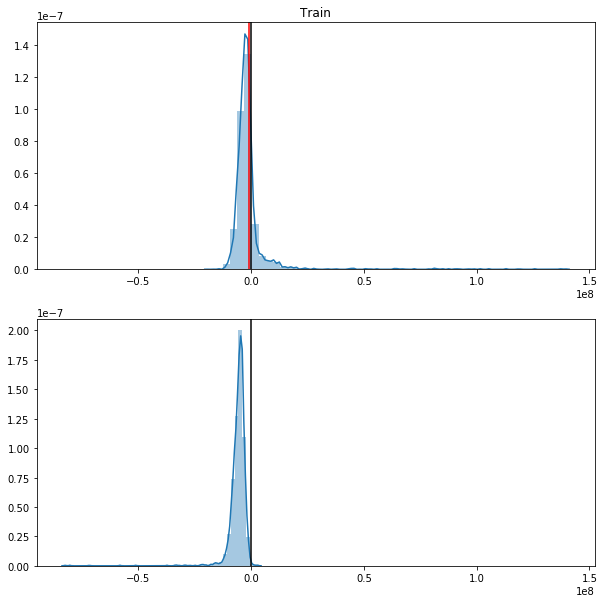

In [76]:
plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
mse_diff = mses_train["MSE(Y_pred,X_t-1)"]-mses_train["MSE(X_pred,X_t-1)"]
sb.distplot(mse_diff)
plt.axvline(0,c='k')
plt.title("Train")
plt.axvline(mse_diff.mean(),c='r')
plt.subplot(2,1,2,sharex=ax)
sb.distplot(mses_train["MSE(Y_pred,Y_t+5)"]-mses_train["MSE(X_pred,Y_t+5)"])
plt.axvline(0,c='k')

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


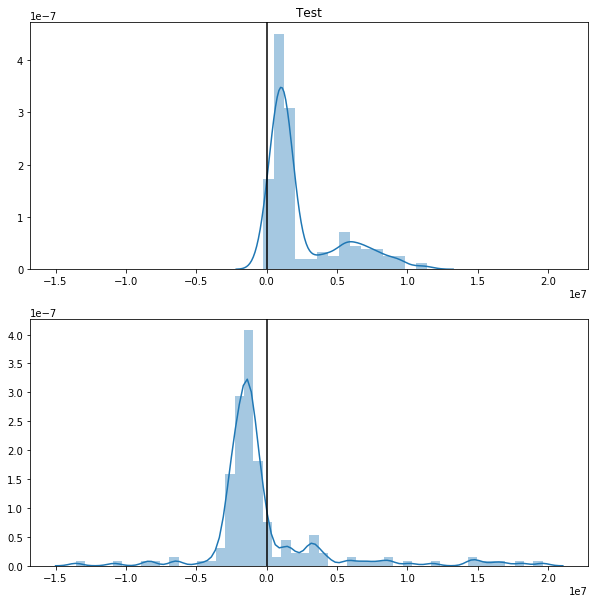

In [68]:
plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
sb.distplot(mses_test["MSE(Y_pred,X_t)"]-mses_test["MSE(X_pred,X_t)"])
plt.axvline(0,c='k')
plt.title("Test")
plt.subplot(2,1,2,sharex=ax)
sb.distplot(mses_test["MSE(Y_pred,Y_t+5)"]-mses_test["MSE(X_pred,Y_t+5)"])
plt.axvline(0,c='k')

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


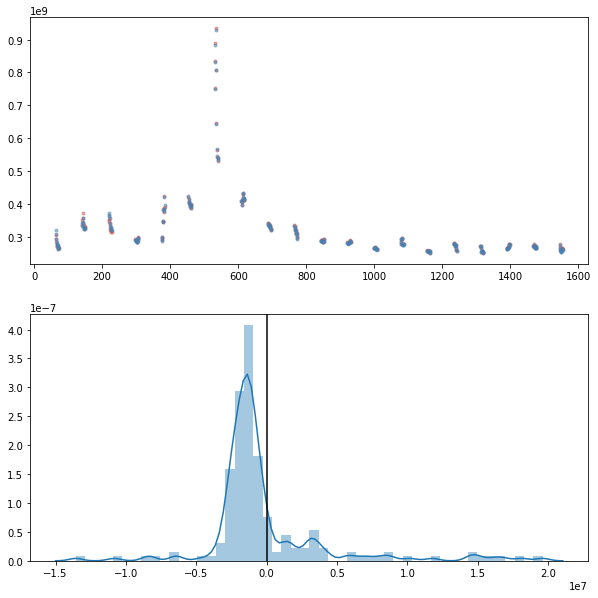

In [62]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(tvt_split["test"],mses_test["MSE(X_pred,Y_t+5)"],'.',c='indianred',alpha=0.5)
plt.plot(tvt_split["test"],mses_test["MSE(Y_pred,Y_t+5)"],'.',c='steelblue',alpha=0.5)
plt.subplot(2,1,2)
sb.distplot(mses_test["MSE(Y_pred,Y_t+5)"]-mses_test["MSE(X_pred,Y_t+5)"])
plt.axvline(0,c='k')

In [54]:
tvt_split["test"]

[63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 460,
 461,
 462,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 616,
 617,
 618,
 687,
 688,
 689,
 690,
 691,
 692,
 693,
 694,
 695,
 696,
 765,
 766,
 767,
 768,
 769,
 770,
 771,
 772,
 773,
 774,
 843,
 844,
 845,
 846,
 847,
 848,
 849,
 850,
 851,
 852,
 921,
 922,
 923,
 924,
 925,
 926,
 927,
 928,
 929,
 930,
 999,
 1000,
 1001,
 1002,
 1003,
 1004,
 1005,
 1006,
 1007,
 1008,
 1077,
 1078,
 1079,
 1080,
 1081,
 1082,
 1083,
 1084,
 1085,
 1086,
 1155,
 1156,
 1157,
 1158,
 1159,
 1160,
 1161,
 1162,
 1163,
 1164,
 1233,
 1234,
 1235,
 1236,
 1237,
 1238,
 1239,
 1240,
 1241,
 1242,
 1311,
 131

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


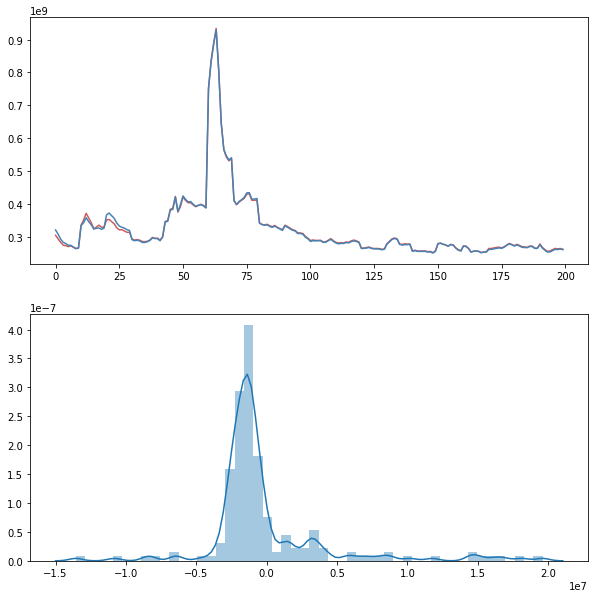

In [50]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(mses_test["MSE(X_pred,Y_t+5)"],c='indianred')
plt.plot(mses_test["MSE(Y_pred,Y_t+5)"],c='steelblue')
plt.subplot(2,1,2)
sb.distplot(mses_test["MSE(Y_pred,Y_t+5)"]-mses_test["MSE(X_pred,Y_t+5)"])

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


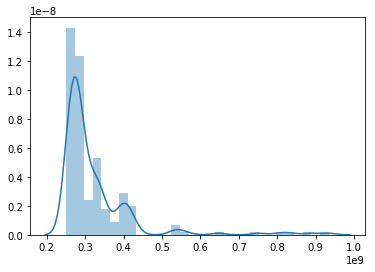

In [40]:
sb.distplot(mses_test["MSE(X_pred,Y_t+5)"])

(array([ 2.,  1.,  2.,  2.,  1.,  1.,  2.,  3.,  2., 10., 10., 14., 96.,
        46.,  2.,  2.,  2.,  0.,  1.,  1.]),
 array([-19607680. , -17949451.2, -16291222.4, -14632993.6, -12974764.8,
        -11316536. ,  -9658307.2,  -8000078.4,  -6341849.6,  -4683620.8,
         -3025392. ,  -1367163.2,    291065.6,   1949294.4,   3607523.2,
          5265752. ,   6923980.8,   8582209.6,  10240438.4,  11898667.2,
         13556896. ]),
 <a list of 20 Patch objects>)

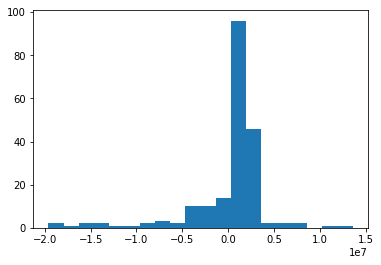

In [29]:
plt.hist(mses_test["MSE(X_pred,Y_t+5)"] - mses_test["MSE(Y_pred,Y_t+5)"],20)

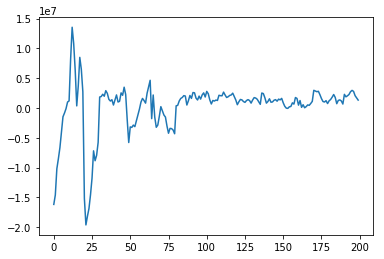

In [30]:
plt.plot(mses_test["MSE(X_pred,Y_t+5)"] - mses_test["MSE(Y_pred,Y_t+5)"])

In [31]:
conv_model.eval()

conv_model.module.pred_bn1.track_running_stats

True

In [35]:
mses = mses_test
idx = np.argsort(mses['MSE(X_t,Y_t+1)'])#[-250:]

Text(0.5,1,'Distribution of MSE(X_pred,Y_pred)')

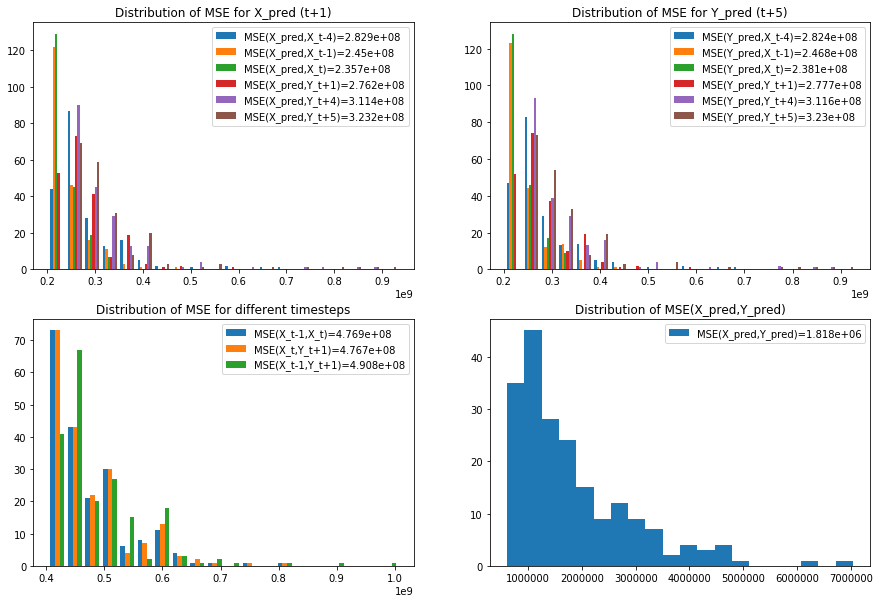

In [36]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title("Distribution of MSE for X_pred (t+1)")
labels = ['MSE(X_pred,X_t-4)', 'MSE(X_pred,X_t-1)', 'MSE(X_pred,X_t)',
          'MSE(X_pred,Y_t+1)', 'MSE(X_pred,Y_t+4)', 'MSE(X_pred,Y_t+5)']
vals = [mses[k][idx] for k in labels]
plt.hist(np.stack(vals,1), 20)
plt.legend(["{}={:.4g}".format(k,m.mean()) for k, m in zip(labels, vals)])

plt.subplot(2,2,2)
labels = ['MSE(Y_pred,X_t-4)', 'MSE(Y_pred,X_t-1)', 'MSE(Y_pred,X_t)',
          'MSE(Y_pred,Y_t+1)', 'MSE(Y_pred,Y_t+4)', 'MSE(Y_pred,Y_t+5)']
vals = [mses[k][idx] for k in labels]
plt.hist(np.stack(vals,1), 20)
plt.legend(["{}={:.4g}".format(k,m.mean()) for k, m in zip(labels, vals)])
plt.title("Distribution of MSE for Y_pred (t+5)")

plt.subplot(2,2,3)
labels = ['MSE(X_t-1,X_t)', 'MSE(X_t,Y_t+1)',
          'MSE(X_t-1,Y_t+1)']
vals = [mses[k][idx] for k in labels]
plt.hist(np.stack(vals,1), 20)
plt.legend(["{}={:.4g}".format(k,m.mean()) for k, m in zip(labels, vals)])
plt.title("Distribution of MSE for different timesteps")

plt.subplot(2,2,4)
labels = ['MSE(X_pred,Y_pred)']
vals = [mses[k][idx] for k in labels]
plt.hist(np.stack(vals,1), 20)
plt.legend(["{}={:.4g}".format(k,m.mean()) for k, m in zip(labels, vals)])
plt.title("Distribution of MSE(X_pred,Y_pred)")


In [37]:
scipy.stats.wilcoxon(mses_test['MSE(X_pred,Y_t+5)'],
                         mses_test['MSE(Y_pred,Y_t+5)'])#,
#                         alternative='greater')

WilcoxonResult(statistic=6094.0, pvalue=1.386098221833191e-06)

In [38]:
scipy.stats.wilcoxon(mses_test['MSE(X_pred,Y_t+5)'],
                         mses_test['MSE(Y_pred,Y_t+5)'])#,
#                         alternative='greater')

WilcoxonResult(statistic=6094.0, pvalue=1.386098221833191e-06)

(array([ 1.,  1.,  2.,  3.,  0.,  1.,  0.,  1.,  3.,  2.,  2.,  3., 10.,
         9., 12., 78., 60.,  5.,  1.,  2.,  1.,  1.,  1.,  0.,  1.]),
 array([-19606752. , -18280230.4, -16953708.8, -15627187.2, -14300665.6,
        -12974144. , -11647622.4, -10321100.8,  -8994579.2,  -7668057.6,
         -6341536. ,  -5015014.4,  -3688492.8,  -2361971.2,  -1035449.6,
           291072. ,   1617593.6,   2944115.2,   4270636.8,   5597158.4,
          6923680. ,   8250201.6,   9576723.2,  10903244.8,  12229766.4,
         13556288. ]),
 <a list of 25 Patch objects>)

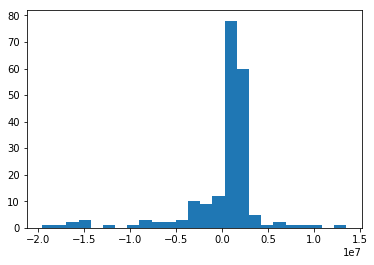

In [97]:
plt.hist(mses['MSE(X_pred,Y_t+5)'] -
                         mses['MSE(Y_pred,Y_t+5)'], 25)#,
#                         alternative='greater')

In [25]:
for k,v in mses.items():
    if k[:11]=="MSE(Y_pred,":
        print("{}: {:.4g}".format(k,v.mean()))

MSE(Y_pred,X_t-1): 2.554e+08
MSE(Y_pred,X_t-2): 2.669e+08
MSE(Y_pred,X_pred): 1.718e+07
MSE(Y_pred,X_t-3): 2.784e+08
MSE(Y_pred,Y_pred): 0
MSE(Y_pred,X_t): 2.442e+08
MSE(Y_pred,X_t-4): 2.901e+08
MSE(Y_pred,Y_t+4): 2.692e+08
MSE(Y_pred,Y_t+3): 2.683e+08
MSE(Y_pred,Y_t+2): 2.685e+08
MSE(Y_pred,Y_t+1): 2.696e+08
MSE(Y_pred,Y_t+5): 2.722e+08


def plot_model_vs_real(model,data):
    plt.figure(figsize=(30,15))

    with T.no_grad():
        for i in range(4):
            time = np.random.randint(len(data))
            z = np.random.randint(nZ)
            X, Y = data[time]
            X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
            Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
            x = X[None].cuda()
            Y_shock = Y_shock[None].cuda()
            y = Y[None].cuda()
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(x, Y_shock)
            mse_X = float(F.mse_loss(X_pred,x[:,0]).cpu())
            mse_X_pred_to_Y = float(F.mse_loss(X_pred,y[:,0]).cpu())
            mse_Y_pred_to_X = float(F.mse_loss(Y_pred,x[:,-1]).cpu())
            mse_Y = float(F.mse_loss(Y_pred,y[:,-1]).cpu())
            prev_loss = float(F.mse_loss(x[:,0],y[:,-1]).cpu())
#             x_zero_loss = float(F.mse_loss(x,T.zeros_like(x)).cpu())
#             y_zero_loss = float(F.mse_loss(y,T.zeros_like(y)).cpu())
            mymin = min(float(y[0,:,z].min()[0]),float(x[0,:,z].min()[0]),float(X_pred[0,z].min()[0]))
            mymax = max(float(y[0,:,z].max()[0]),float(x[0,:,z].max()[0]),float(X_pred[0,z].max()[0]))
            
            plt.subplot(4,4,i*4+1)
            plt.imshow(X[-1,z].cpu().numpy(), vmin=mymin, vmax=mymax)
            plt.title("Time="+str(time) + ", z="+str(z))
            
            plt.subplot(4,4,i*4+2)
            plt.imshow(Y[0,z].cpu().numpy(), vmin=mymin, vmax=mymax)
            plt.title("Time="+str(time+1) + ", z="+str(z))
            
            plt.subplot(4,4,i*4+3)
            plt.imshow(X_pred[0,z].cpu().numpy(), vmin=mymin, vmax=mymax)
            plt.title("MSE: (X_pred,X)={:.0f}, (X_pred,Y)={:.0f}".format(mse_X,mse_X_pred_to_Y))
            
            plt.subplot(4,4,i*4+4)
            plt.imshow(Y_pred[0,z].cpu().numpy(), vmin=mymin, vmax=mymax)
            plt.title("MSE: (Y_pred,Y)={:.0f}, (Y_pred,X)={:.0f}".format(mse_Y,mse_Y_pred_to_X))

plot_model_vs_real(conv_model.module,data)

# def get_gradient_from_embedding(model,frame,embedding,niters=20, lr=1e-3):
#     model.eval()
#     frame = frame.cuda()
#     frame.requires_grad = True
#     embedding_pred, _ = model.encode(frame)
#     print(embedding_pred.shape)
#     embedding_pred.backward(gradient=embedding)
#     model.train()
#     return frame.grad[0]

# def get_input_from_embedding(model,frame,embedding,niters=75, lr=1e-1, rand=False):
#     "Take an embedding vector, and use backprop to find the volume"
#     if rand:
#         prev_img = T.rand_like(frame[None], requires_grad=True).cuda()
#     else:
#         prev_img = frame[None].cuda()
#         prev_img.requires_grad = True
#     optimizer = T.optim.Adam([prev_img],lr=lr)
#     model.eval()
#     for i in range(niters):
#         embedding_pred, _ = model.encode(prev_img)
#         loss = F.mse_loss(embedding_pred,embedding[None]) #+ 1e-7*T.norm(prev_img,1)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
# #         print("iter {} loss: ".format(i), float(loss))
#     model.train()
#     return prev_img[0].detach().cpu().numpy()

def interpret(model,prev_vol, next_vol, nEmbedding):
    "Plot prev & next frame for each latent dimension"
    plt.figure(figsize=(10,40))
    
    embedding = T.from_numpy(np.zeros(nEmbedding).astype(np.float32)).cuda()[None]
#     shock = T.FloatTensor([0,1])[:,None,None].cuda()
    shock = T.cuda.FloatTensor(2,1,prev_frames).zero_()
    shock[0] = T.zeros(1,prev_frames)
    shock[1] = T.ones(1,prev_frames)
    with T.no_grad():
        prev_img = model.decode(embedding)[0][0] # ignore tail
        next_img = model.decode(model.predict(embedding,shock[0]))[0][0] # ignore tail
        next_img_shock = model.decode(model.predict(embedding,shock[1]))[0][0]
        
    plt.subplot(1+nEmbedding,4,1)
    plt.imshow(prev_img[6])
    plt.title("Prev (Zero Vector)")
    
    plt.subplot(1+nEmbedding,4,2)
    plt.imshow(next_img[6])
    plt.title("Next (Zero Vector)")
    
    plt.subplot(1+nEmbedding,4,3)
    plt.imshow(next_img[6] - prev_img[6])
    plt.title("Diff (Zero Vector)")
    
    plt.subplot(1+nEmbedding,4,4)
    plt.imshow(next_img_shock[6])
    plt.title("Next (Shock)")
    for i in range(nEmbedding):
        embedding = T.from_numpy(np.eye(nEmbedding)[i].astype(np.float32)).cuda()[None]
        with T.no_grad():
            prev_img = model.decode(embedding)[0][0]
            next_img = model.decode(model.predict(embedding,shock[0]))[0][0]
            next_img_shock = model.decode(model.predict(embedding,shock[0]))[0][0]
        plt.subplot(1+nEmbedding,4,i*4+5)
        plt.imshow(prev_img[6])
        plt.title("Prev (Dim {})".format(i))
        
        plt.subplot(1+nEmbedding,4,i*4+6)
        plt.imshow(next_img[6])
        plt.title("Next (Dim {})".format(i))
        
        plt.subplot(1+nEmbedding,4,i*4+7)
        plt.imshow(next_img[6]-prev_img[6])
        plt.title("Diff (Dim {})".format(i))
        
        plt.subplot(1+nEmbedding,4,i*4+8)
        plt.imshow(next_img_shock[6])
        plt.title("Next w/ shock (Dim {})".format(i))
    plt.tight_layout()

x, y = data[1000]
interpret(conv_model.module,x,y,nEmbedding)

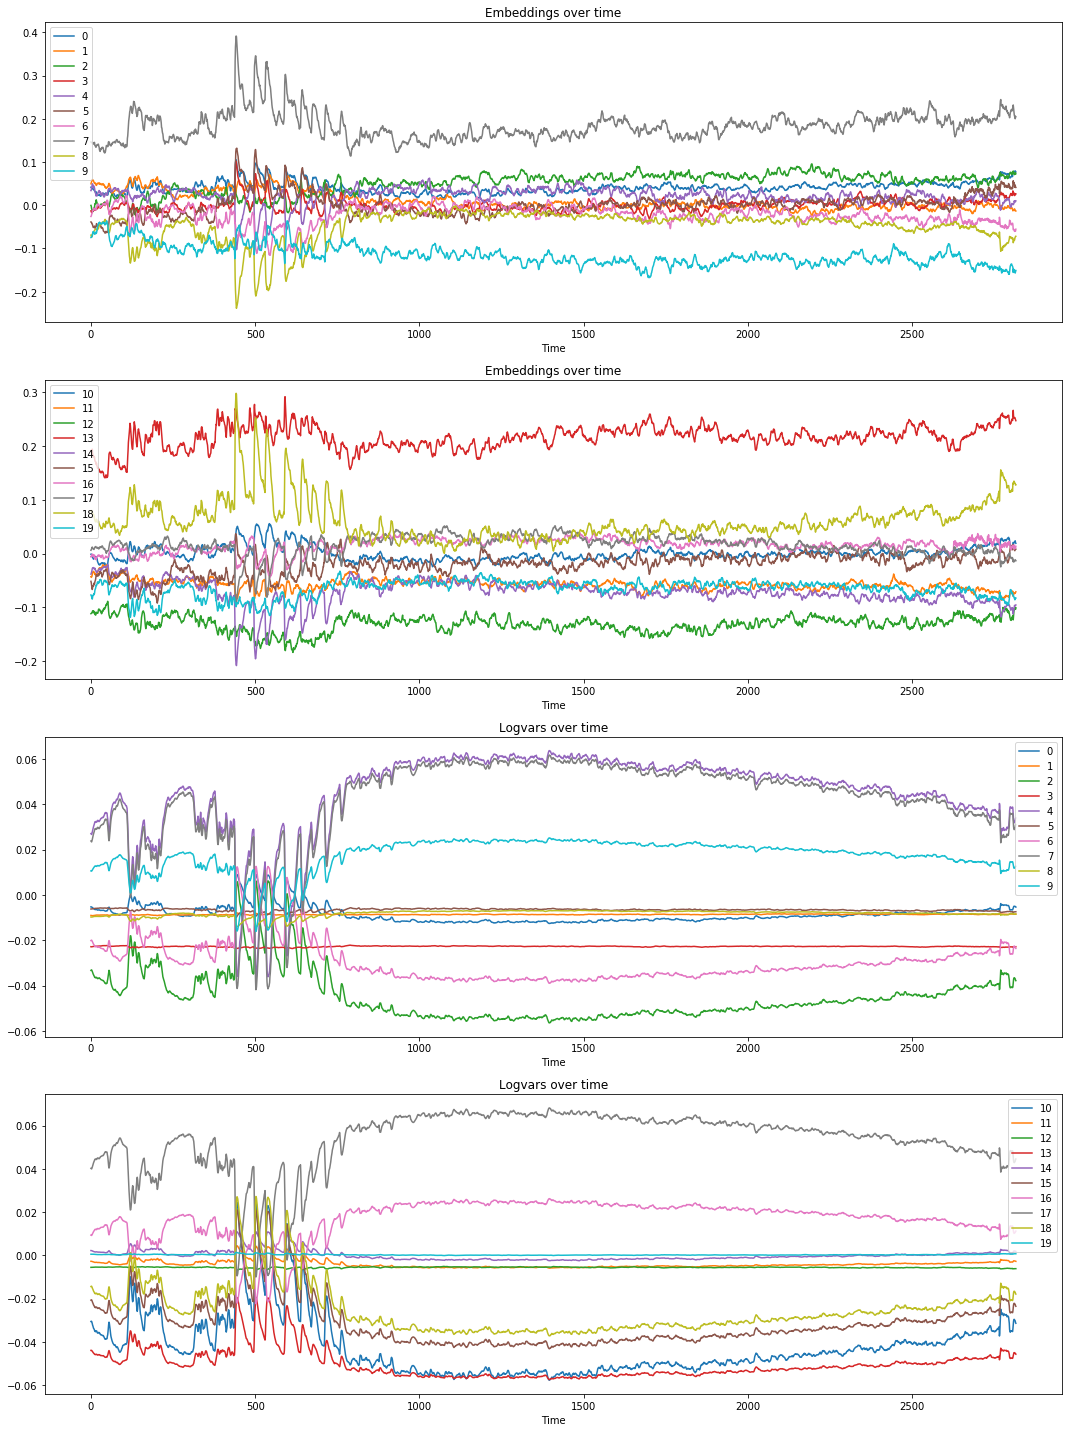

In [27]:
def plot_embedding_over_time(model,data, batch_size=64):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    embeddings = []
    logvars = []
    model.eval()
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            embedding, logvar, _ = model.encode(X.cuda())
        embeddings.append(embedding.cpu().numpy())
        logvars.append(logvar.cpu().numpy())
    model.train()
    embeddings = np.vstack(embeddings)
    logvars = np.vstack(logvars)
    nEmbeddings = embeddings.shape[1]
    half = int(np.ceil(nEmbeddings / 2))
    
    plt.figure(figsize=(15,20))
    plt.subplot(4,1,1)
    plt.plot(embeddings[:,0:half])
    plt.title("Embeddings over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half))
    plt.subplot(4,1,2)
    plt.plot(embeddings[:,half:])
    plt.title("Embeddings over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half,nEmbeddings))
    
    plt.subplot(4,1,3)
    plt.plot(logvars[:,0:half])
    plt.title("Logvars over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half))
    plt.subplot(4,1,4)
    plt.plot(logvars[:,half:])
    plt.title("Logvars over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half,nEmbeddings))
    
    plt.tight_layout()
    return embeddings
embeddings = plot_embedding_over_time(conv_model.module,data)

In [79]:
all_data

Bunch(c=[<passivity_2p_imaging_utils.Passivity_2p_Fish object at 0x7f1d20081310>, <passivity_2p_imaging_utils.Passivity_2p_Fish object at 0x7f1d20081850>, <passivity_2p_imaging_utils.Passivity_2p_Fish object at 0x7f1d20081890>, <passivity_2p_imaging_utils.Passivity_2p_Fish object at 0x7f1d200818d0>, <passivity_2p_imaging_utils.Passivity_2p_Fish object at 0x7f1d20081910>, <passivity_2p_imaging_utils.Passivity_2p_Fish object at 0x7f1d20081950>, <passivity_2p_imaging_utils.Passivity_2p_Fish object at 0x7f1d20081990>, <passivity_2p_imaging_utils.Passivity_2p_Fish object at 0x7f1d200819d0>], e=[<passivity_2p_imaging_utils.Passivity_2p_Fish object at 0x7f1d20081a10>, <passivity_2p_imaging_utils.Passivity_2p_Fish object at 0x7f1d20081a50>, <passivity_2p_imaging_utils.Passivity_2p_Fish object at 0x7f1d20081a90>, <passivity_2p_imaging_utils.Passivity_2p_Fish object at 0x7f1d20081ad0>, <passivity_2p_imaging_utils.Passivity_2p_Fish object at 0x7f1d20081b10>, <passivity_2p_imaging_utils.Passivity_

In [107]:
imaging.mean(0)

(11, 116, 256)

# WIP mean added back
def scale_for_vid(arr, mymin, mymax):
    return ((arr - mymin) * (1/(mymax - mymin)) * 255).astype('uint8')

import skvideo.io
def makePredVideo(model, data, mean_fish, batch_size=32):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    writer = skvideo.io.FFmpegWriter(model_name + "_test_prediction.mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    mymax = float(T.cat([test_data[i][0]['brain']+mean_fish for i in np.arange(len(test_data))]).max())
    mymin = float(T.cat([test_data[i][0]['brain']+mean_fish for i in np.arange(len(test_data))]).min())
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), _, _= model(X.cuda(),Y_shock.cuda())
        for x, x_pred, y, y_pred in zip(X,X_pred,Y,Y_pred):
            # 7th z layer
            zslice = x_pred[6]
            H = zslice.shape[0]
            W = zslice.shape[1]
            frame = np.zeros([H*2,W*3])
            
            frame[:H, :W] = y[0,6]+mean_fish
            frame[:H, W:(2*W)] = y[-1,6] - y[0,6]
            frame[:H, (2*W):] = y[-1,6]+mean_fish
            frame[H:, :W] = x_pred[6]+mean_fish
            frame[H:, W:(2*W)] = y_pred[6] - y[0,6] #x_pred[6]
            frame[H:, (2*W):] = y_pred[6]+mean_fish
            writer.writeFrame(scale_for_vid(frame,mymin,mymax))
    writer.close()
    return frame

mean_fish = T.from_numpy(imaging.mean(0)).cuda()
frame = makePredVideo(conv_model,test_data, mean_fish)

plt.imshow(frame)

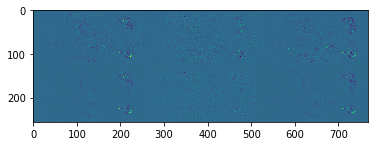

In [114]:
def scale_for_vid(arr, mymin, mymax):
    return ((arr - mymin) * (1/(mymax - mymin)) * 255).astype('uint8')

import skvideo.io
def makePredVideo(model, data, batch_size=32):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    writer = skvideo.io.FFmpegWriter(model_name + "_test_prediction.mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    mymax = float(T.cat([test_data[i][0]['brain'] for i in np.arange(len(test_data))]).max())
    mymin = float(T.cat([test_data[i][0]['brain'] for i in np.arange(len(test_data))]).min())
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), _, _= model(X.cuda(),Y_shock.cuda())
        for x, x_pred, y, y_pred in zip(X,X_pred,Y,Y_pred):
            # 7th z layer
            zslice = x_pred[6]
            H = zslice.shape[0]
            W = zslice.shape[1]
            frame = np.zeros([H*2,W*3])
            
            frame[:H, :W] = y[0,6]
            frame[:H, W:(2*W)] = y[-1,6] - y[0,6]
            frame[:H, (2*W):] = y[-1,6]
            frame[H:, :W] = x_pred[6]
            frame[H:, W:(2*W)] = y_pred[6] - y[0,6].cuda() #x_pred[6]
            frame[H:, (2*W):] = y_pred[6]
            writer.writeFrame(scale_for_vid(frame,mymin,mymax))
    writer.close()
    return frame
frame = makePredVideo(conv_model,test_data)

plt.imshow(frame)

In [100]:
T.cat([test_data[i][0]['brain'] for i in np.arange(len(test_data))]).max()

tensor(905.3982)

In [101]:
T.cat([test_data[i][0]['brain'] for i in np.arange(len(test_data))]).min()

tensor(-694.5835)

In [86]:
test_data[np.arange(len(test_data))][0].max()

TypeError: only integer scalar arrays can be converted to a scalar index

In [53]:
class FishDistanceData(Dataset):
    def __init__(self, imaging, distance):
        data = imaging - imaging.mean(0)
        self.data = T.from_numpy(data)
        self.distance=distance
        
    def __len__(self):
        return self.data.shape[0]-self.distance

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx+self.distance]

def MSEbyDist(imaging, maxdist=10, batch_size=256):
    mse = []
    
    with T.no_grad():
        for d in range(1,maxdist+1):
            data = FishDistanceData(imaging,d)
            dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
            mse.append([])
            for batch_data in tqdm(dataloader):
                X, Y = batch_data
                X = X.cuda()
                Y = Y.cuda()
                mse[d-1].append(volume_mse(X, Y).cpu())

    mse = [T.cat(m).numpy() for m in mse]
    return mse

mse = MSEbyDist(imaging,10)

plt.hist(mse)
plt.legend(["MSE distance {}={:.4g}".format(d+1,m.mean()) for d, m in enumerate(mse)])

KeyboardInterrupt: 

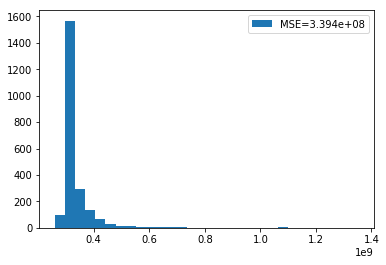

In [74]:
class FishMAData(Dataset):
    def __init__(self, imaging, ma=5, nfuture=1, index_map=None):
        data = imaging - imaging.mean(0)
        self.data = T.from_numpy(data)
        self.ma=ma
        self.nfuture=nfuture
        self.index_map=index_map
        
    def __len__(self):
        if self.index_map:
            return len(self.index_map)
        else:
            return self.data.shape[0]-self.ma-self.nfuture

    def __getitem__(self, i):
        if self.index_map:
            idx = self.index_map[i]
        else:
            idx = i
        return self.data[(idx-self.ma+1):(idx+1)].mean(0), self.data[idx+self.nfuture]

def MSE_MA(imaging, ma=5, nfuture=1, batch_size=256, index_map=None):
    mse = []
    with T.no_grad():
        data = FishMAData(imaging, ma, nfuture,index_map)
        dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X = X.cuda()
            Y = Y.cuda()
            mse.append(volume_mse(X, Y).cpu())

    return T.cat(mse).numpy()

mse = MSE_MA(imaging, 5, 5, 256, tvt_split['train'])

plt.hist(mse,30)
plt.legend(["MSE={:.4g}".format(mse.mean())])

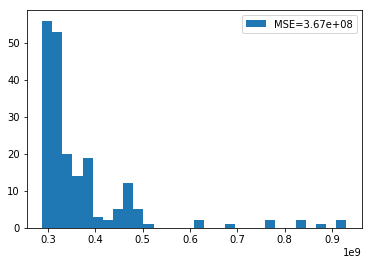

In [75]:
mse = MSE_MA(imaging, 5, 5, 256, tvt_split['test'])

plt.hist(mse,30)
plt.legend(["MSE={:.4g}".format(mse.mean())])